In [3]:
from scapy.all import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

In [7]:
# OLD
def createDataFrame(pkt_lst):
    protos = []
    dst_type = []
    
    for pkt in pkt_lst:
        try:  
            ptype = {
                0x0800: 'IPv4',
                0x0806: 'ARP',
                0x8137: 'IPX',
                0x86dd: 'IPv6',
                0x88cc: 'LLDP'
            }.get(pkt.type, pkt.type)
        except AttributeError:
            ptype = 'Other'
            pass
        if ptype != 'Other':
            protos.append(ptype)
            isBcast = pkt.dst == 'ff:ff:ff:ff:ff:ff'
            if isBcast:
                dst_type.append("broadcast")
            else:
                dst_type.append("unicast")
    
    data_dict = {'protocolos': protos, 'destinos': dst_type}
    
    return pd.DataFrame.from_dict(data_dict)

def probability_chart(df):
    total =  df.shape[0]
    return (df.groupby(['simbolo']).size() / total).reset_index(name='probabilidad')

def entropy_old(df):
    probs = probability_chart(df)
    sum = 0
    for index, row in probs.iterrows():
        prob = row['probabilidad']
        sum += prob * (- math.log2(prob))
        print(prob, (- math.log2(prob)))
    return sum

def max_entropy_old(df):
    return math.log2(df.groupby(['protocolos', 'destinos']).size().reset_index().count()[0])

def plotProtocols(dframe, size=(8,8)):
    dframe.protocolos.value_counts(sort=False).plot.pie(figsize=size)

def getNoTypePkts(pkt_lst):
    pkts = []

    for pkt in pkt_lst:
        try:  
            ptype = pkt.type
        except AttributeError:
            pkts.append(pkt)
            pass
        
    return pkts
# NEW
def createDataFrame_s1(pkt_lst):
    protos = []
    dsts = []
    for pkt in pkt_lst:
        try:  
            ptype = {
                0x0800: 'IPv4',
                0x0806: 'ARP',
                0x8137: 'IPX',
                0x86dd: 'IPv6',
                0x88cc: 'LLDP'
            }.get(pkt.type, pkt.type)
        except AttributeError:
            ptype = 'Other'
            pass
        if ptype != 'Other':
            protos.append(ptype)
            isBcast = pkt.dst == 'ff:ff:ff:ff:ff:ff'
            if isBcast:
                dsts.append("broadcast")
            else:
                dsts.append("unicast")
    
    data_dict = {'protocolo': protos, 'dst': dsts}
    
    df = pd.DataFrame.from_dict(data_dict)
    df['simbolo'] = df['protocolo'] + ' ' + df['dst']
    
    return df
    
def createDataFrame_s2(pkt_lst):
    arp_type = []
    srcs = []
    dsts = []
    for pkt in pkt_lst:
        if scapy.layers.l2.ARP in pkt and pkt.psrc != pkt.pdst:
            if scapy.layers.l2.ARP.is_at == pkt.op:
                arp_type.append('is-at')
            else:
                arp_type.append('who-has')
            srcs.append(pkt.psrc)
            dsts.append(pkt.pdst)

    data_dict = {'tipo': arp_type, 'src': srcs, 'dst': dsts}

    df = pd.DataFrame.from_dict(data_dict)
    df['simbolo'] = df['tipo'] + ' ' + df['dst'] 
    
    return df
    



In [9]:
def summaryDataFrame(df):
    total =  df.shape[0]
    size = df.groupby(['simbolo']).size()
    prob = size / total
    info = prob.apply(math.log2) * -1
    
    return pd.DataFrame({'simbolo':size.index, 'total':size.values, 'prob': prob.values, 'info': info.values})

def entropy(df):
    return sum(df["prob"] * df["info"])

def max_entropy(df):
    return math.log2(sum(df.total))

In [8]:
def plot_simbols_pie(df):
    df.groupby('simbolo').size().plot.pie()
def plot_dest_type_pie(df):
    df.groupby('dst').size().plot.pie()
def plot_prob_bar(summ): # Hay que mandarle el summaryDataFrame
    ax = sns.barplot(x="simbolo", y="prob", data=summ)
    ax.set(xlabel='Simbolo', ylabel='Probabilidad')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
def plot_info_bar(summ): # Hay que mandarle el summaryDataFrame
    ax = sns.barplot(x="simbolo", y="info", data=summ)
    ax.set(xlabel='Simbolo', ylabel='Informacion')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
    ax.axhline(y=max_entropy(summ), xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
    ax.axhline(y=entropy(summ), xmin=-1, xmax=1, color='r', linestyle='-', lw=2)

In [1]:
def net_graph(df):
    G = nx.Graph()

    for index, row in df.iterrows():
        G.add_node(row['src'])
        G.add_node(row['dst'])
        G.add_edge(row['src'], row['dst'])
    nx.draw(G, pos=nx.spring_layout(G))

In [83]:
# packets_mc = rdpcap("mc.cap")
# packets_desp = rdpcap("desp.cap")
# packets_naxio = rdpcap("pruebamac.cap")
# packets_home = rdpcap("home.cap")
#packets_mh = rdpcap("manu_home.pcap")
lastDespeCap = "despe.cap"
macCap = "mac.cap"
packets = rdpcap(macCap)


In [84]:
data_s1 = createDataFrame_s1(packets)
summary_s1 = summaryDataFrame(data_s1)
data_s2 = createDataFrame_s2(packets)
summary_s2 = summaryDataFrame(data_s2)

entropy: 1.5110599539794516  max_entropy: 13.715104009236168


,simbolo,total,prob,info
0,ARP broadcast,8168,0.607377,0.719337
1,ARP unicast,363,0.026993,5.211278
2,IPv4 broadcast,2233,0.166047,2.590336
3,IPv4 unicast,2602,0.193486,2.369699
4,IPv6 unicast,82,0.006098,7.357552


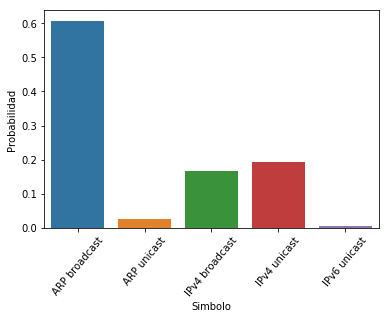

In [85]:
print("entropy:",  entropy(summary_s1), " max_entropy:", max_entropy(summary_s1))
plot_prob_bar(summary_s1)
summary_s1

entropy: 1.146397508444987  max_entropy: 8.751544059089099


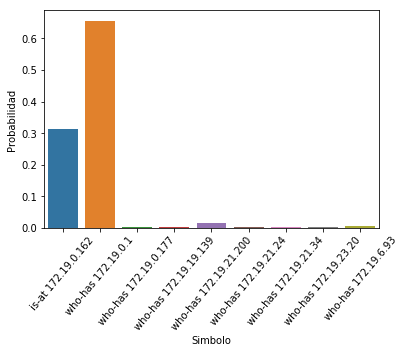

In [86]:
print("entropy:",  entropy(summary_s2), " max_entropy:", max_entropy(summary_s2))
# A este grafico hay que modificarlo para que no se vean todos los simbolos o something like that
plot_prob_bar(summary_s2)

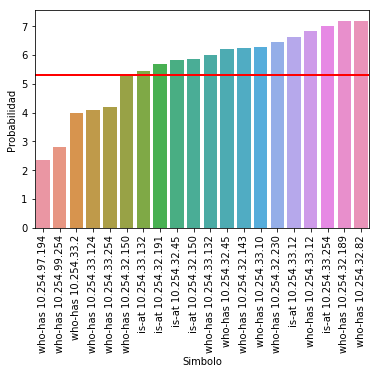

In [75]:
ax = sns.barplot(x="simbolo", y="info", data=summary_s2.sort_values('info', ascending=True).iloc[0:20])
ax.set(xlabel='Simbolo', ylabel='Probabilidad')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.axhline(y=entropy(summary_s2), xmin=-1, xmax=1, color='r', linestyle='-', lw=2)

In [55]:
data_s1 = createDataFrame_s1(packets)
summary_s1 = summaryDataFrame(data_s1)

12.687375683437468

In [53]:
packets_mac = rdpcap("pruebamac.cap")

In [54]:
data_mac = createDataFrame_s1(packets_mac)
summary_mac = summaryDataFrame(data_mac)

In [55]:
summary_mac

,simbolo,total,prob,info
0,ARP broadcast,8168,0.607377,0.719337
1,ARP unicast,363,0.026993,5.211278
2,IPv4 broadcast,2233,0.166047,2.590336
3,IPv4 unicast,2602,0.193486,2.369699
4,IPv6 unicast,82,0.006098,7.357552


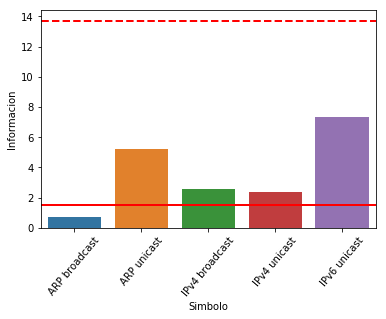

In [56]:
plot_info_bar(summary_mac)

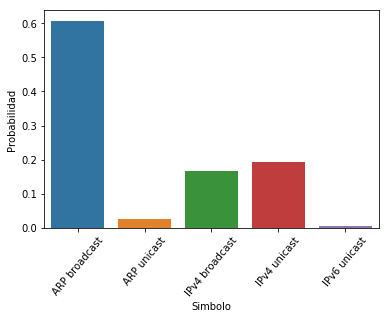

In [57]:
plot_prob_bar(summary_mac)

In [46]:
packets_mh = rdpcap("manu_home.pcap")

In [47]:
data_mh = createDataFrame_s1(packets_mh)
summary_mh = summaryDataFrame(data_mh)

In [49]:
summary_mh

,simbolo,total,prob,info
0,ARP broadcast,62,0.005632,7.472199
1,ARP unicast,15,0.001363,9.519505
2,IPv4 broadcast,59,0.005359,7.543753
3,IPv4 unicast,8851,0.803979,0.314771
4,IPv6 unicast,2022,0.183668,2.444829


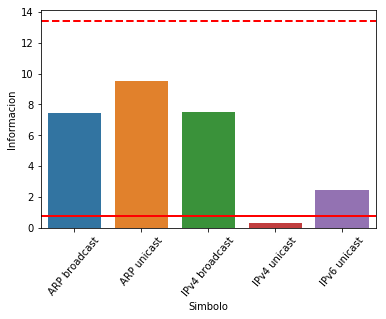

In [50]:
plot_info_bar(summary_mh)

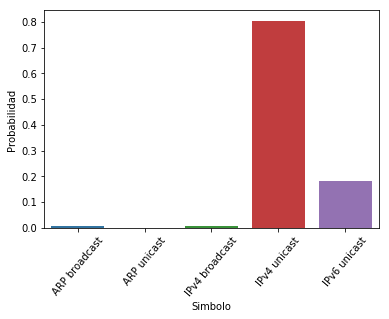

In [51]:
plot_prob_bar(summary_mh)

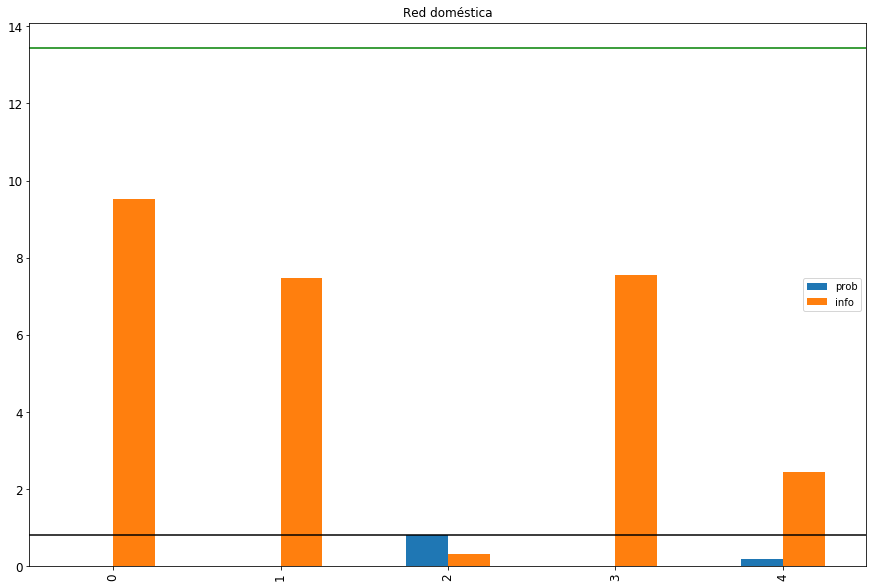

In [18]:
# Esto en realidad tendria que estar en ejes separados
graph_mh = data_mh[['prob','info']].plot(kind='bar', title ="Red doméstica", figsize=(15, 10), legend=True, fontsize=12)
graph_mh.axhline(entropy(data_mh), color='k', label='Entropía')
graph_mh.axhline(max_entropy(data_mh), color='g', label='Entropía máxima')

In [91]:
#data_s2.groupby(['tipo', 'dst']).size().sort_values( ascending=False)
packets

<mac.cap: TCP:1444 UDP:3314 ICMP:35 Other:8655>